In [1]:
# Implementation of core Gradient Descent optimization algorithm

# importing necessary libraries

import jax
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import numdifftools as nd
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["figure.autolayout"] = True

import random
np.random.seed(69)
random.seed(69)


In [2]:
import tensorflow as tf

2023-01-28 14:12:58.815188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/soft/centOS/lib/gnu/tcl/8.4.20/lib:/home/civil/visitor/amanp.visitor/anaconda3/lib/
2023-01-28 14:12:59.212487: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-28 14:13:13.709087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/soft/centOS/lib/gnu/tcl/8.4.20/lib:/home/civil/visitor/amanp.visitor/anaconda3/lib/
2023-01-28 14:13:13.709866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

# Truss

In [3]:
# defining the geometery of truss

E = 1e7 #68947572.93178 # KN/m^2 (10e7 psi) modulus_of_elasticity
p = 0.1  #27.1447138 # KN/m^3 (0.1 lb/in^3) weight_density
s_lim = 25000 #172368.93233 #KN/m^2 (25000 psi) # allowable_stress_compression = 172368.93233 #KN/m^2 (25000 psi)
d_lim =  2 #0.0508 #m (2 inch) #displacemnt limit

In [4]:
area_avalival = [1.62, 1.80,2.38, 2.62, 2.88, 3.09, 3.13,
3.38,3.63,3.84,3.87,4.18,4.49,4.80,4.97,5.12, 5.74, 7.22,
7.97,11.5,13.5,13.9,14.2,15.5,16.0,18.8,19.9,22.0,22.9,
26.5, 30.0, 33.5]  ## sq inch

In [5]:
nodes, bars =[], []

nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2

bars.append([3,4]) #bar3
bars.append([4,5]) #bar4


bars.append([1,4]) #bar5
bars.append([2,5]) #bar6

bars.append([0,4]) #bar7
bars.append([1,3]) #bar8

bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

In [6]:
bars

array([[0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [1, 4],
       [2, 5],
       [0, 4],
       [1, 3],
       [1, 5],
       [2, 4]])

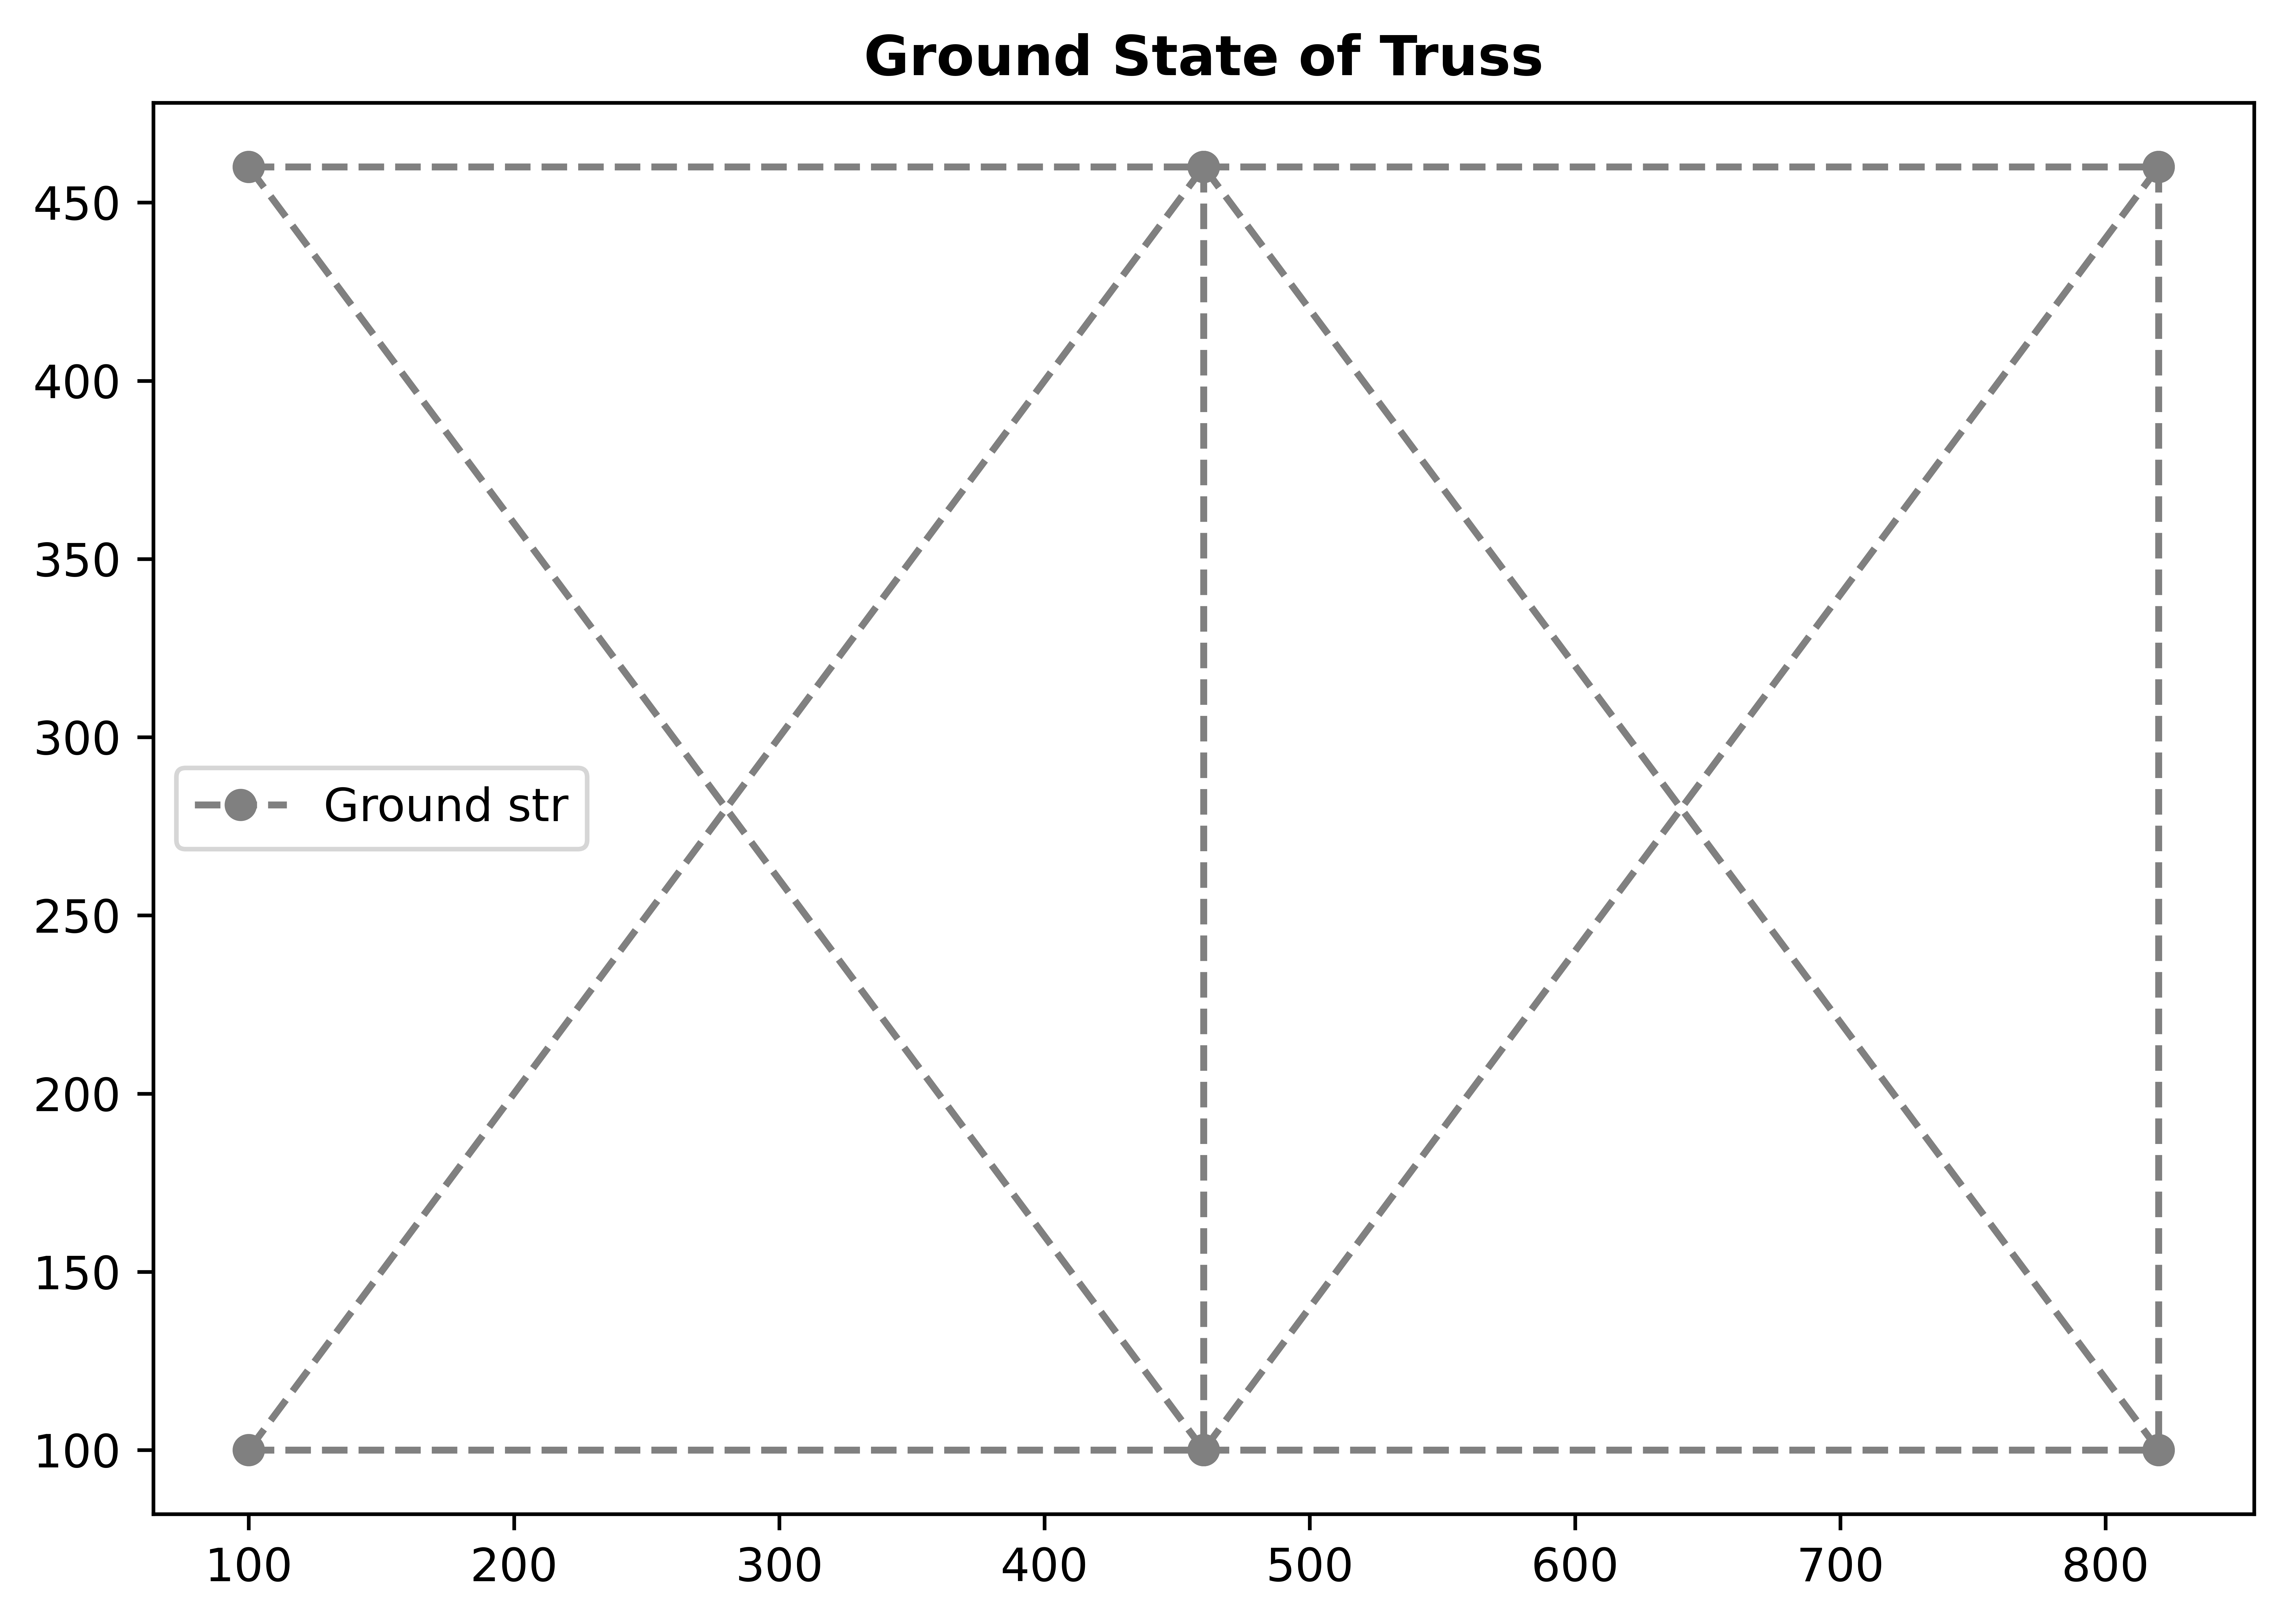

In [7]:
plt.figure(figsize=(7,5))
plt.title("Ground State of Truss", fontweight='bold')
for i in range(len(bars)):
    xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
    yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
    line, = plt.plot([xi, xf], [yi, yf], color='grey', linestyle='--', marker='o') 

line.set_label('Ground str')
plt.legend()
plt.show()

In [8]:
P = np.zeros_like(nodes) # 0 =nO LOAD # 1 == lOAD
P[4,1]= -100000
P[5,1]= -100000
print(P)

[[      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0. -100000.]
 [      0. -100000.]]


In [9]:
Ur = [0,0,0,0]

In [10]:
# Defining the degrees of Freedoms
DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[3,:] = 0
print(DOFCON)

[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [11]:
# Truss Analysis
# Doing structural analysis of the truss for an constant area of 11.5 inch^2

In [12]:
@jax.jit
class basic(): 

    def min_area(area):
        computed_area =[]
        for i in area:
            if i<1:
                computed_area.append(1)
            else:
                computed_area.append(i)
        return np.array(computed_area)

    def area_gen(area):
        area_new = []
        for i in range(10):
            area_new.append(random.choice(area))
        return area_new

    def scaler(area):
        f=[]
        a = sum(area)
        for i in area:
            i=i*50
            f.append(i/a)
        return f

    def Plot(nodes, c, lt, area, lg):
        for i in range(len(bars)):
            xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
            yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
            a = np.round(basic.scaler(area), 3)
            line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=a[i],
                             label=f'\nArea : {area[i]} in^2\n', marker='o', solid_capstyle='round') #
        line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=0.001, solid_capstyle='round')
        line.set_label(lg)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':4})
    

    def check( STRESS, DEFLECTION):
        x=0
        y=0
        for i in STRESS:
            if (np.abs(i) > s_lim).any():
                x +=1
                # print("Failed in Stress")
            else:
                pass
                #print("Pass in Stress")
        for i in range(6):
            ix = np.abs(DEFLECTION[i][0])
            iy = np.abs(DEFLECTION[i][1])
            if (ix > d_lim).any():
                y+=1
                #print("Failed in Deflection along X")
            elif (iy > d_lim).any():
                y +=1
                #print("Failed in Deflection along Y")
            else:
                pass
                #print("Pass in Deflection")
        if (x ==0) and (y==0):
            # print("Pass")
            return "Pass"
        else:
            # print(f'Failed in {x} ways for stress \n Failed in {y} ways for deflection ')
            return f'Failed in {x} ways for stress \n Failed in {y} ways for deflection '

@jax.jit
class Truss():
    # Truss Structural Analysis
    def TrussAnalysis(A, nodes, bars):
        NN = len(nodes) # number of nodes
        NE = len(bars) # number of deges
        # print(NE)

        DOF = 2 # defree of freedom
        NDOF = DOF*NN # total degree of freedom

        #structural analysis using direct stifness method

        # for bar no 3
        # takes info from node no 3 and substract it from infor of node no 2
        d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
        
        L = np.sqrt((d**2).sum(axis=1)) #leangth of the bar
        # print(f"The Leangth is {L}")
        #computing the angle 
        angle = d.T/L
        # print(f"The angle is \n\n{angle}\n\n")
        #transformation vector {a ==Transformation vector}
        a = np.concatenate((-angle.T, angle.T), axis=1)
        # print(f"The transformation vector is \n\n{a}\n\n")

        #Global stifness matrix K
        K = np.zeros([NDOF,NDOF])
        
        
        for k in range(NE):
            aux = 2*bars[k,:]
            #gives you degree of freedom in each node
            index = np.r_[aux[0]:aux[0]+2, aux[1]:aux[1]+2]
            # print(f'a : {a.shape}, A: {A.shape}, L: {L.shape}')
            ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
            # print(f"Stifness Matrix \n\n{ES}\n\n")
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES

        freeDOF = DOFCON.flatten().nonzero()[0]
        supportDOF = (DOFCON.flatten()==0).nonzero()[0]

        Kff = K[np.ix_(freeDOF, freeDOF)]
        Kfr = K[np.ix_(freeDOF, supportDOF)]
        Krf = Kfr.T
        # print(f'{Kfr}, \n \n {Kff}, \n \n {Krf}')
        Krr = K[np.ix_(supportDOF, supportDOF)]
        
        Pf = P.flatten()[freeDOF]
        #Uf = np.linalg.solve(Kff, Pf) #.lstsq
        Uf = np.linalg.inv(Kff)@ Pf
        U  = DOFCON.astype(float).flatten()
        U[freeDOF] = Uf
        U[supportDOF] = Ur

        U = U.reshape(NN, DOF) #displacement of the truss members
        u = np.concatenate((U[bars[:,0]], U[bars[:,1]]), axis=1)
        # print(E)
        # print(A)
        N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
        R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
        R = R.reshape(2,DOF)

        # Stress
        S = N/A

        #weight of str
        Volume = (1*A*L).sum() #for mass replace 1 by p

        #check
        c = basic.check(S, U)

        return S, Volume, U, c, R

basic = jax.jit(basic)
Truss = jax.jit(Truss)

In [13]:
x = np.array([20 for i in range(10)]).astype(float)
x

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [14]:
Truss.TrussAnalysis(x, nodes, bars)

(array([  9768.24934844,   2006.23161277, -10231.75065156,  -2993.76838723,
          1774.48096122,   2006.23161277,   7398.81272639,  -6743.32289734,
          4233.82785582,  -2837.23995605]),
 83929.35059634515,
 array([[ 0.        ,  0.        ],
        [ 0.35165698, -0.83717623],
        [ 0.42388131, -1.89756315],
        [ 0.        ,  0.        ],
        [-0.36834302, -0.90105754],
        [-0.47611869, -1.96978749]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

In [15]:
import tensorflow as tf

# Define the function to minimize
def function(x):
    return (2*x - 5)**2

# Define the variables to optimize
x = tf.Variable(-10.0)

# Define the loss function
loss = function(x)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Define the number of training steps
num_steps = 1000

# Train the model
for step in range(num_steps):
    # Compute gradients
    grads, = tf.gradients(loss, [x])
    # Update variables
    optimizer.apply_gradients(zip([grads], [x]))
    # Print the current value of the variable
    if step % 100 == 0:
        print("Step:", step, "x:", x.numpy())

# Print the minimum value
print("Minimum value found:", function(x).numpy())


2023-01-28 14:13:43.598832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/soft/centOS/lib/gnu/tcl/8.4.20/lib:/home/civil/visitor/amanp.visitor/anaconda3/lib/
2023-01-28 14:13:43.603606: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [16]:

import numpy as np

def cost(x):
    return (2*x-5)**2


def gradient(x):
    return nd.Gradient(cost)(x)

def optimize():
    
    x = np.random.rand() # initial x value
    alpha = 0.1 # learning rate
    beta1 = 0.9 # decay rate for first moment estimate
    beta2 = 0.999 # decay rate for second moment estimate
    eps = 1e-3 # small constant to avoid division by zero
    m = np.ones_like(x) # first moment estimate
    v = np.ones_like(x) # second moment estimate
    t = 0 # iteration counter
    learning_rate = 0.1
    max_steps = 20

    # for step in range(max_steps):
    for step in range(max_steps):
        t += 1
        grad = gradient(x) # 2*x*3 # gradient of the objective function with respect to x
        m = beta1*m + (1-beta1)*grad # update first moment estimate
        v = beta2*v + (1-beta2)*(grad**2) # update second moment estimate
        m_hat = m / (1 - beta1**t) # bias-corrected first moment estimate
        v_hat = v / (1 - beta2**t) # bias-corrected second moment estimate
        x -= alpha * m_hat / (np.sqrt(v_hat) + eps) # update x
  
        
        # # Compute the current cost
        cost_value = cost(x)
        
        # # Print progress
        # # if step % 100 == 0:
        print("Step: {} x: {} Cost: {}".format(step, x, cost_value))

optimize()


Step: 0 x: 0.3200939680036333 Cost: 19.00796123333658
Step: 1 x: 0.36680052121716245 Cost: 18.202160065117482
Step: 2 x: 0.4250206116647169 Cost: 17.22215784806506
Step: 3 x: 0.4902682685293568 Cost: 16.156086529919957
Step: 4 x: 0.5601868390816501 Cost: 15.051500397088159
Step: 5 x: 0.6333443253315374 Cost: 13.937613631087894
Step: 6 x: 0.7087826655054142 Cost: 12.833838157575556
Step: 7 x: 0.7858129913564653 Cost: 11.753748402409078
Step: 8 x: 0.8639105910835506 Cost: 10.707154215874306
Step: 9 x: 0.9426562549321659 Cost: 9.701278161207627
Step: 10 x: 1.0217014065024477 Cost: 8.741466926147366
Step: 11 x: 1.1007463672848838 Cost: 7.831642914665797
Step: 12 x: 1.1795263126542601 Cost: 6.974603035889819
Step: 13 x: 1.2578019578322635 Cost: 6.172223903861431
Step: 14 x: 1.3353532769400718 Cost: 5.425607958136917
Step: 15 x: 1.411975239969197 Cost: 4.735191513760347
Step: 16 x: 1.4874749372297145 Cost: 4.100828010951883
Step: 17 x: 1.5616696863694308 Cost: 3.521855109912169
Step: 18 x: 1

TypeError: 'numpy.float64' object is not iterable

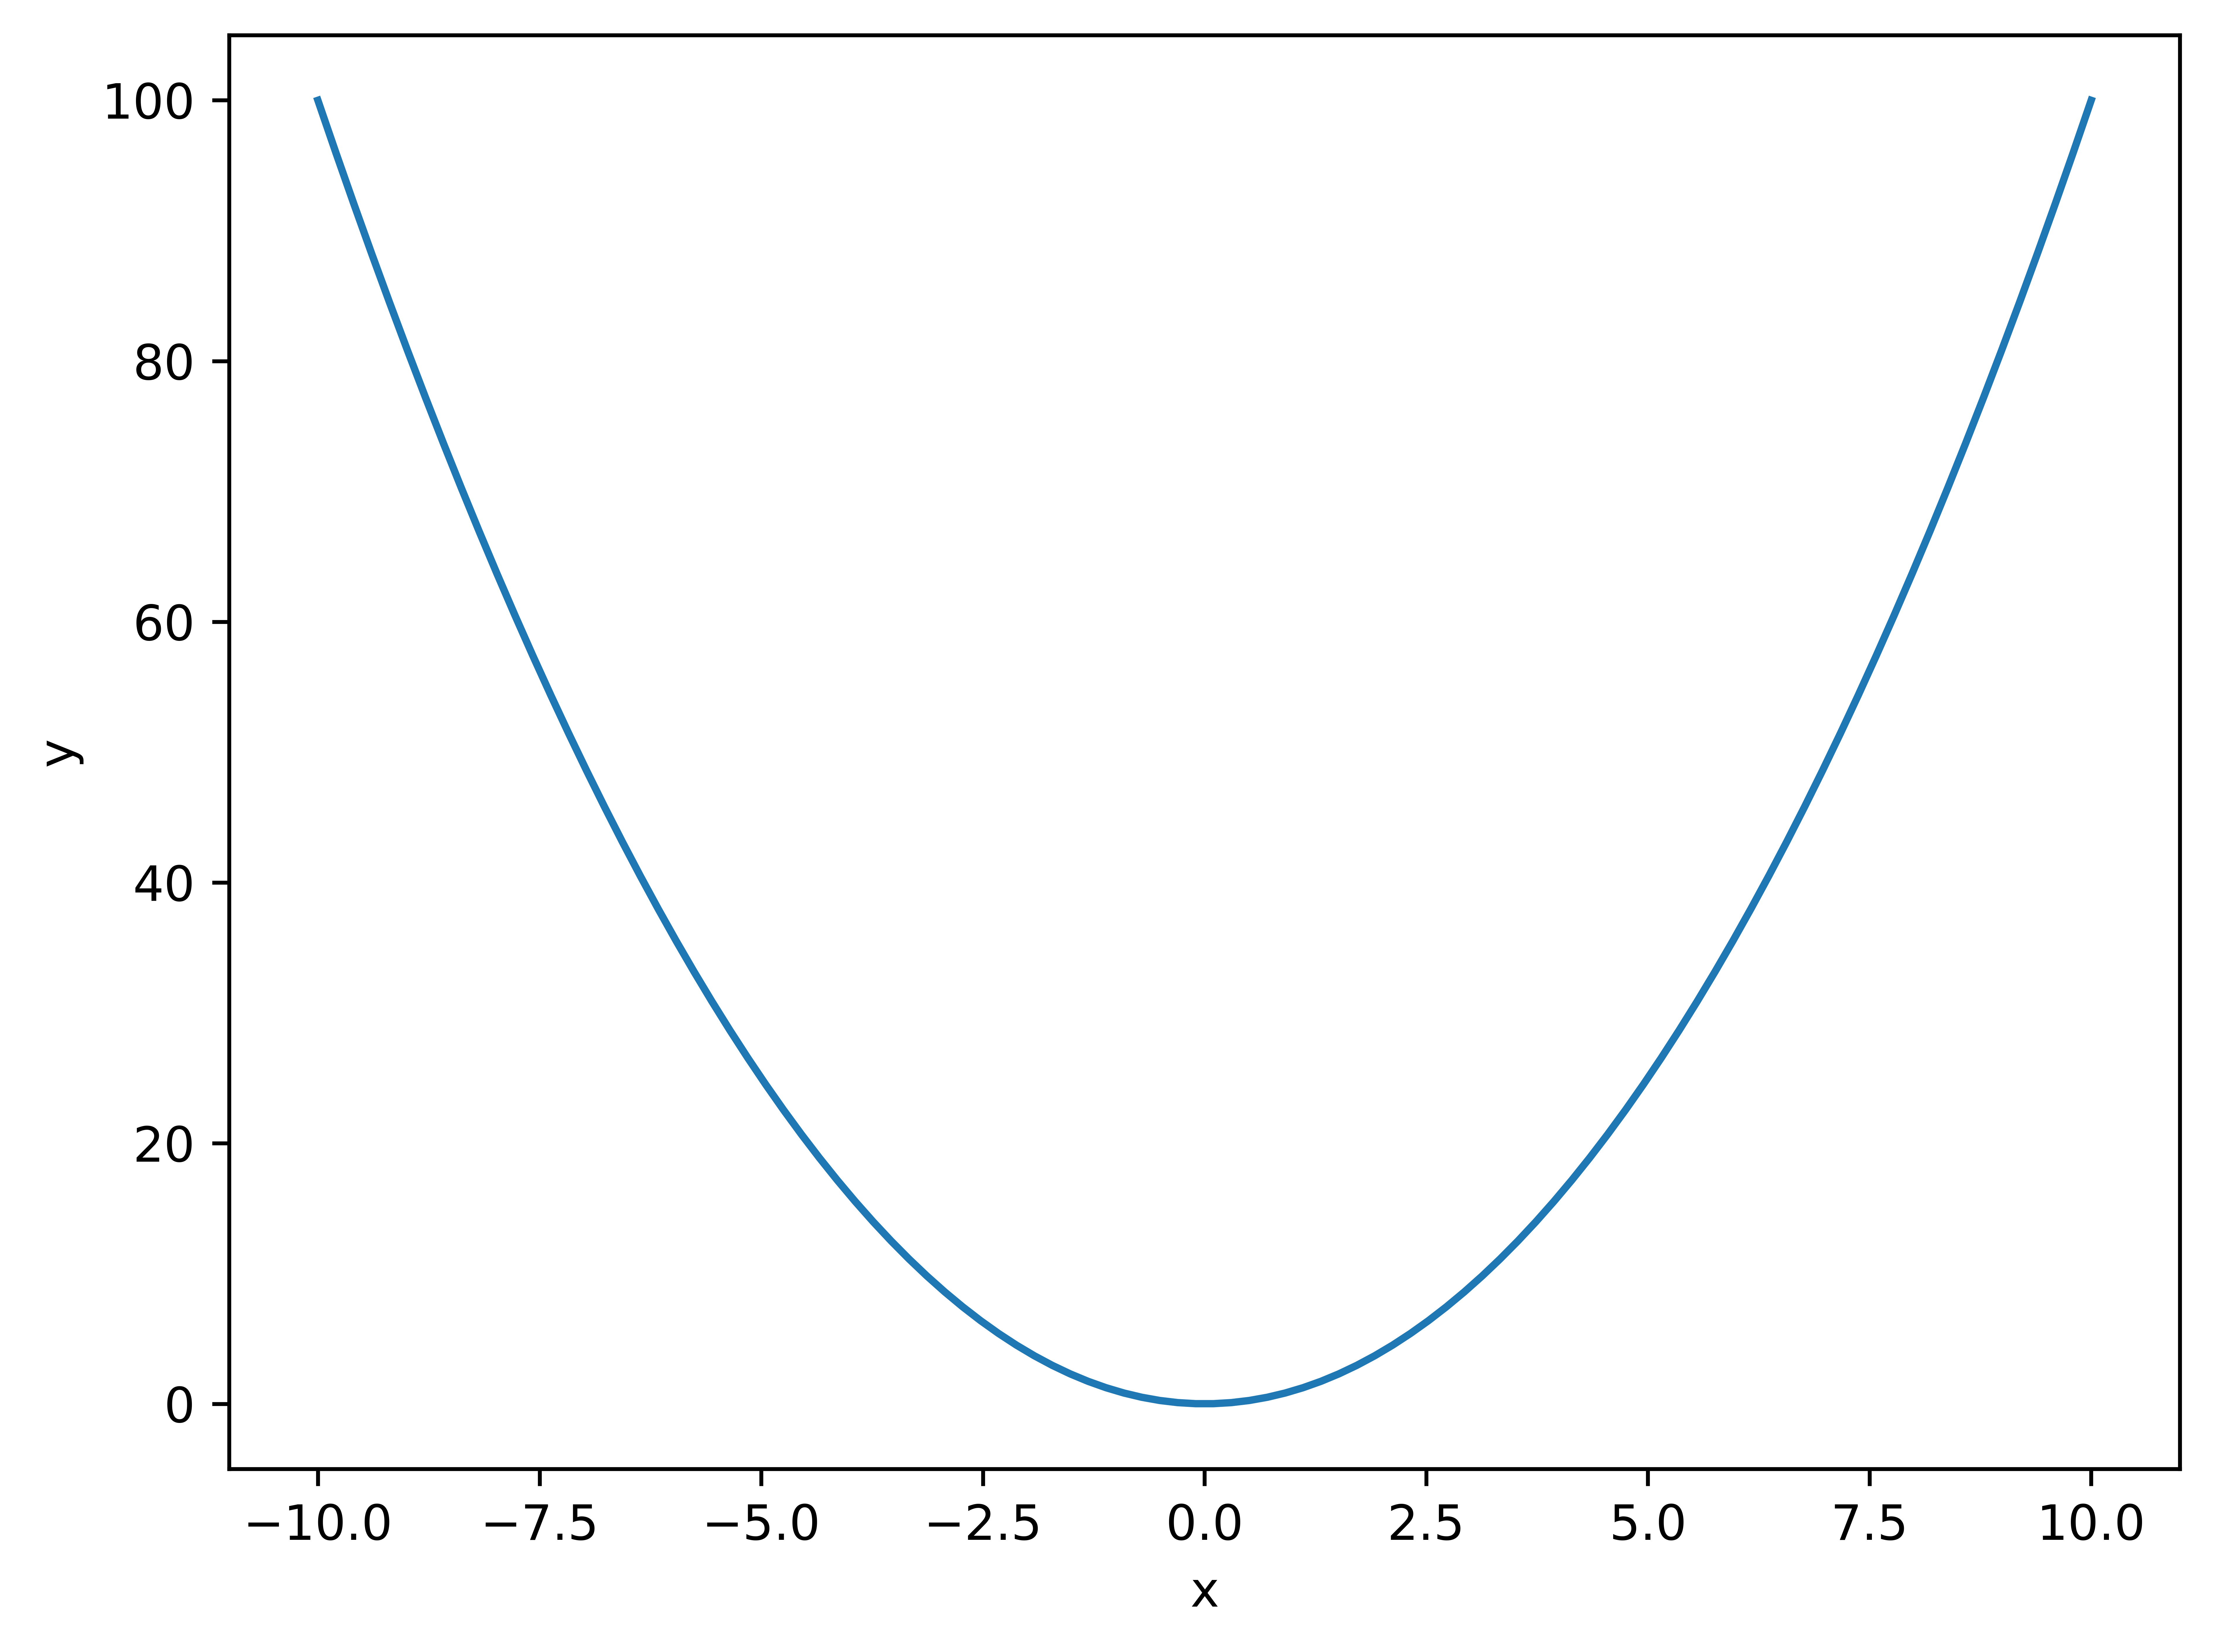

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    # Example function
    return x**2

def check_convexity(f, x):
    # Compute the Hessian of the function
    hess = np.array([[nd.Gradient(lambda x: f(np.array([x[0], y])))[0] for y in x] for x in x])
    # Check if all eigenvalues of the Hessian are positive
    return np.all(np.linalg.eigvals(hess) > 0)

x = np.linspace(-10, 10, 100)
y = f(x)

# Plot the function
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")

if check_convexity(f, x):
    plt.title("The function is convex")
else:
    plt.title("The function is not convex")

plt.show()


In [45]:


def f(x):
    # num = np.array([x]*10)
    ans = Truss.TrussAnalysis(x, nodes, bars)
    L = ans[1] 
    return L.sum()
    
def check_convexity(f,x):
    for i in x:
        initial_area = np.array([i]*10)
        # First-order derivative (gradient) of f
        grad = nd.Gradient(f)(initial_area)
        # Second-order derivative (Hessian) of f
        hess = nd.Gradient(f)(grad)
        #x = np.array(initial_area)
        return np.all(np.linalg.eigvals(hess.reshape(1,-1)) >= 0)


x0 = [1, 2, 3]
print(check_convexity(lambda x: f(x), x0)) #True


LinAlgError: Last 2 dimensions of the array must be square

In [37]:
data, value = [], []
for _ in range(1000):
    x = np.random.rand(10) # np.array([_+1]*10)
    value.append(Truss.TrussAnalysis(x, nodes, bars)[1])
    data.append(x)

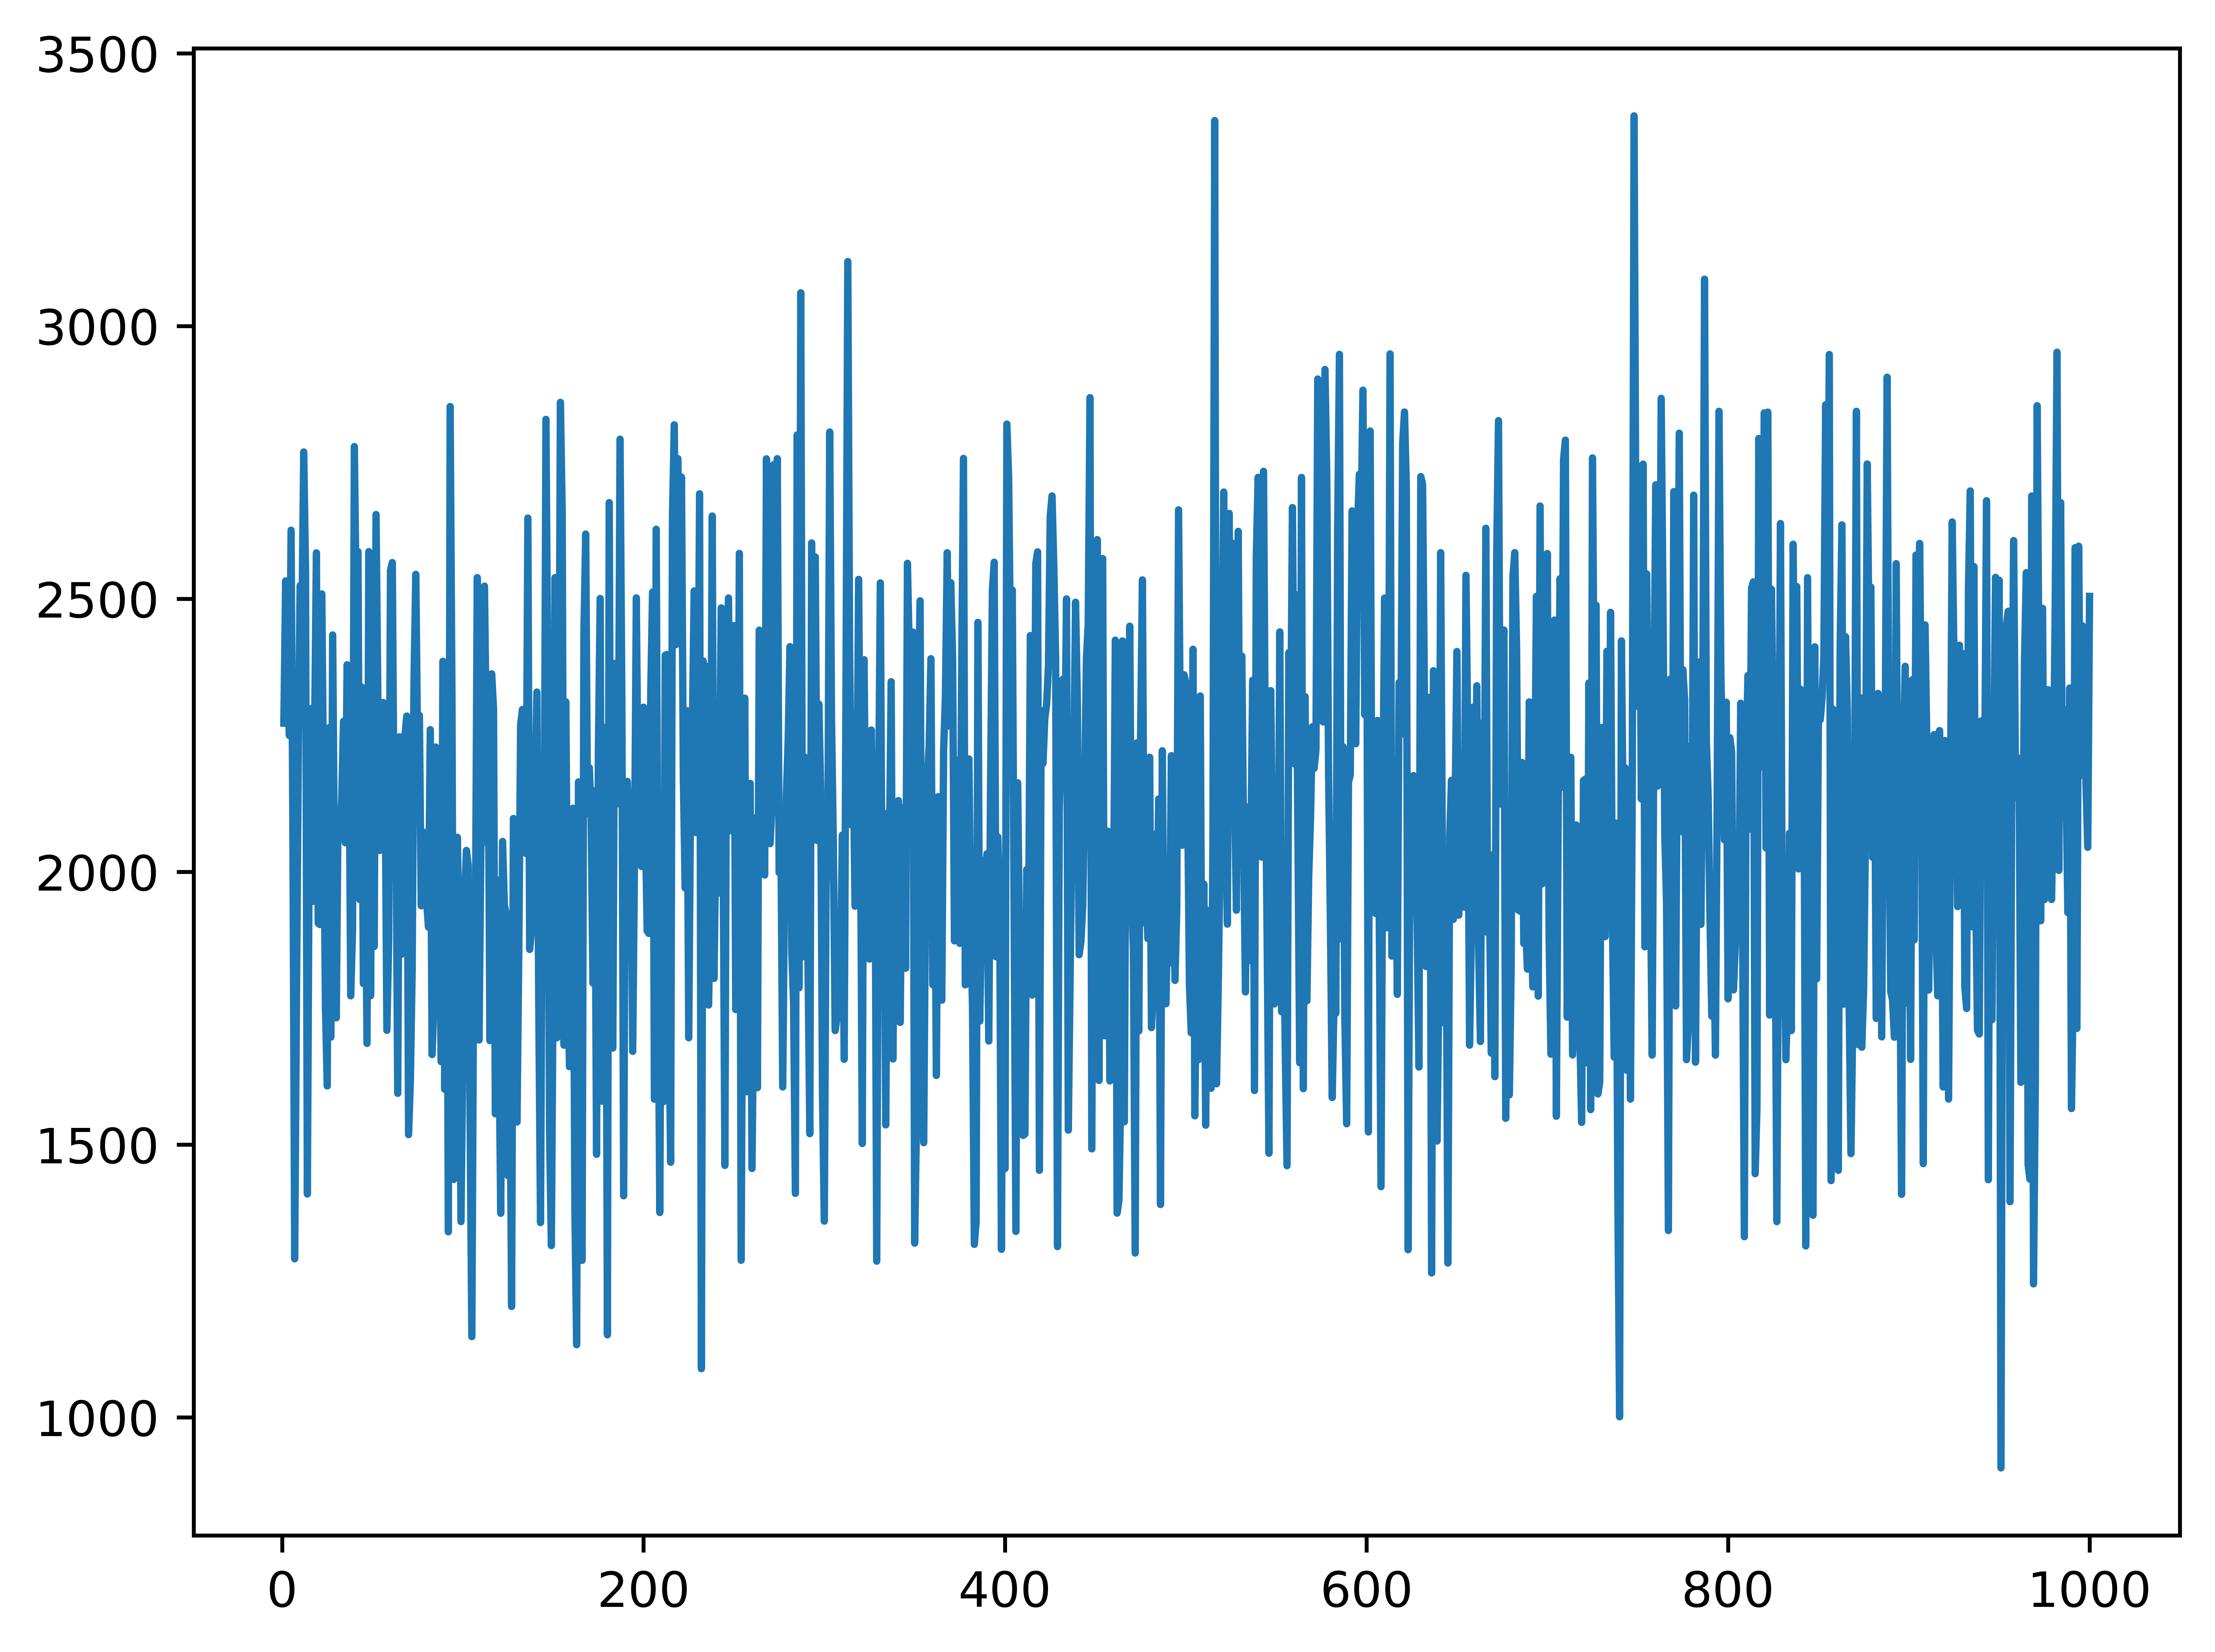

In [38]:
plt.plot(np.linspace(1,1000,1000),value)

In [133]:
pp = Truss.TrussAnalysis(x, nodes, bars)
(pp[0]+pp[1]).sum()

843675.2581886906

In [177]:

def f(x):
    # num = np.array([x]*10)
    ans = Truss.TrussAnalysis(x, nodes, bars)
    L = ans[1] 
    return L.sum()

def cost(x):
    ans = Truss.TrussAnalysis(x, nodes, bars)
    return ans

# def gradient(x, var): # truss_volume_derivative
#     """Function that calculates the derivative of the truss volume with respect to the variable var"""
#     h = 1e-8 # Step size
#     var_index = var - 1 # Index of the variable in the x array
    
#     x_plus_h = np.array(x)
#     x_plus_h[var_index] += h
#     x_minus_h = np.array(x)
#     x_minus_h[var_index] -= h

#     return (cost(x_plus_h)[1] - cost(x_minus_h)[1]) / (2 * h)
# def gradient(x): # truss_volume_derivative
#     """Function that calculates the derivative of the truss volume with respect to the variable var"""
#     h = 1e-8 # Step size
#     gg = []
#     for i in range(len(x)):
        
#         var_index = i # Index of the variable in the x array
        
#         x_plus_h = np.array(x)#[cost(x)[1]]*10
#         x_plus_h[var_index] += h
#         x_minus_h = np.array(x)#[cost(x)[1]]*10
#         x_minus_h[var_index] -= h

#         gg.append((cost(x_plus_h)[1] - cost(x_minus_h)[1]) / (2 * h))

#     return np.array(gg)
    
def comp(x):
    temp = 0
    for i in x:
        if i < 0:
            temp += 1
        else:
            pass
    return temp

# To be used if we want to clip the gradient by certain factor or reduce it.


def optimize(initial_area):
    # x = np.array([100. for i in range(10)]).astype(float) #basic.area_gen([100.0]) # initial x value
    
    max_steps = 10000
    x_new = initial_area
    alpha = np.array([0.1]*len(x)) # learning rate 
    beta1 = np.array([0.9]*len(x)) # decay rate for first moment estimate
    beta2 = np.array([0.999]*len(x)) # 0.999 # decay rate for second moment estimate
    eps = np.array([1e-8]*len(x))  # small constant to avoid division by zero
    m = np.ones_like(x) # first moment estimate
    v = np.ones_like(x) # second moment estimate
    t = 0 # iteration counter
    #learning_rate = 0.1


    vt = []
    for step in range(max_steps):
     
        if (comp(initial_area) == 0) and (cost(initial_area)[3]=="Pass"):
            
            # Compute the gradient
            grad = nd.Gradient(f)(initial_area)
            # grad = clip(grad)
            # print(grad)
            # Update x using gradient descent

            t += 1
            grad = nd.Gradient(f)(initial_area) # 2*x*3 # gradient of the objective function with respect to x
            m = beta1*m + (1-beta1)*grad # update first moment estimate

            v = beta2*v + (1-beta2)*(grad**2) # update second moment estimate
            
            m_hat = m / (1 - beta1**t) # bias-corrected first moment estimate
            v_hat = v / (1 - beta2**t) # bias-corrected second moment estimate
            x_new -= alpha * m_hat / (np.sqrt(v_hat) + eps) # update x

            initial_area = x_new

            # x_new -= grad * np.array([learning_rate]*len(x))
            # print(f"x_new : {x}")
            # Compute the current vol
            cost_value = cost(x_new)[1]
        
            vt.append(cost_value)
            # Print progress
            # if step % 100 == 0:
            #     print("Step: {} Area: {} Volume: {}\n\n".format(step, x, cost_value))
            # else:
            #     pass

            print("Step: {} Area: {} Volume: {}\n\n".format(step, x_new, cost_value))
        else:
            print("Training Saturated the constraint is violation")
            break
    return x_new, vt


In [178]:
area = np.array([20.]*10)

In [179]:
gd = optimize(area)

Step: 0 Area: [19.97138936 19.97152342 19.97120163 19.97149391 19.97151915 19.97152342
 19.97139411 19.97133764 19.97148481 19.97148774] Volume: 83809.47504723989


Step: 1 Area: [19.95211709 19.95244108 19.95166341 19.95236976 19.95243076 19.95244108
 19.95212858 19.9519921  19.95234778 19.95235484] Volume: 83728.86605022821


Step: 2 Area: [19.93713225 19.93768918 19.93635234 19.9375666  19.93767145 19.93768918
 19.93715199 19.93691738 19.9375288  19.93754095] Volume: 83666.3094571152


Step: 3 Area: [19.92477798 19.92560426 19.92362087 19.92542239 19.92557795 19.92560426
 19.92480727 19.9244592  19.92536631 19.92538434] Volume: 83614.84302189927


Step: 4 Area: [19.91426095 19.91538872 19.91268161 19.9151405  19.91535281 19.91538872
 19.91430095 19.91382585 19.91506396 19.91508857] Volume: 83571.13162618146


Step: 5 Area: [19.90512488 19.90658328 19.90308249 19.90626229 19.90653684 19.90658328
 19.90517661 19.90456221 19.90616331 19.90619513] Volume: 83533.25623596099


Step: 6 Are

In [175]:
Truss.TrussAnalysis(np.round(gd[0],2), nodes, bars)

(array([  8544.43796334,   1715.29518073, -11981.08610846,  -3554.93220356,
          1426.43303601,   1715.29518073,   6655.91895609,  -7661.02651065,
          3827.78066161,  -3176.73506465]),
 85561.85371338065,
 array([[ 0.        ,  0.        ],
        [ 0.30759977, -0.85919368],
        [ 0.36935039, -1.93993968],
        [ 0.        ,  0.        ],
        [-0.4313191 , -0.91054526],
        [-0.55929666, -2.00169031]]),
 'Failed in 0 ways for stress \n Failed in 1 ways for deflection ',
 array([[-300000.        ,  106553.92450989],
        [ 300000.        ,   93446.07549011]]))

In [176]:
Truss.TrussAnalysis(gd[0], nodes, bars)

(array([  8544.68018444,   1715.33004181, -11984.31423521,  -3555.89548126,
          1426.68859251,   1715.33004181,   6656.85421652,  -7663.32694565,
          3827.84590069,  -3177.11930326]),
 85552.08947742036,
 array([[ 0.        ,  0.        ],
        [ 0.30760849, -0.85936803],
        [ 0.36936037, -1.94027709],
        [ 0.        ,  0.        ],
        [-0.43143531, -0.91072882],
        [-0.55944755, -2.00202897]]),
 'Failed in 0 ways for stress \n Failed in 1 ways for deflection ',
 array([[-300000.        ,  106551.56456223],
        [ 300000.        ,   93448.43543777]]))

In [115]:
gd[1]

[209400.7334441262,
 208979.8025584658,
 208559.42697217778,
 208139.31793026486,
 207719.36041953682,
 207299.4974189751,
 206879.69680833432,
 206459.93894128292,
 206040.21110780607,
 205620.50475405034,
 205200.81395755138,
 204781.1345321273,
 204361.4634735901,
 203941.79860167683,
 203522.1383208516,
 203102.4814562288,
 202682.8271386649,
 202263.17472297113,
 201843.52372896916,
 201423.87379859778,
 201004.22466447018,
 200584.5761266952,
 200164.92803571885,
 199745.2802795796,
 199325.63277442113,
 198905.98545741558,
 198486.33828147815,
 198066.69121131566,
 197647.04422046983,
 197227.3972891031,
 196807.7504023411,
 196388.1035490301,
 195968.45672080573,
 195548.80991139566,
 195129.1631160957,
 194709.51633137814,
 194289.86955459727,
 193870.22278376878,
 193450.5760174045,
 193030.92925438844,
 192611.2824938835,
 192191.63573526184,
 191771.98897805266,
 191352.3422219029,
 190932.69546654756,
 190513.0487117882,
 190093.4019574757,
 189673.75520349844,
 189254.108

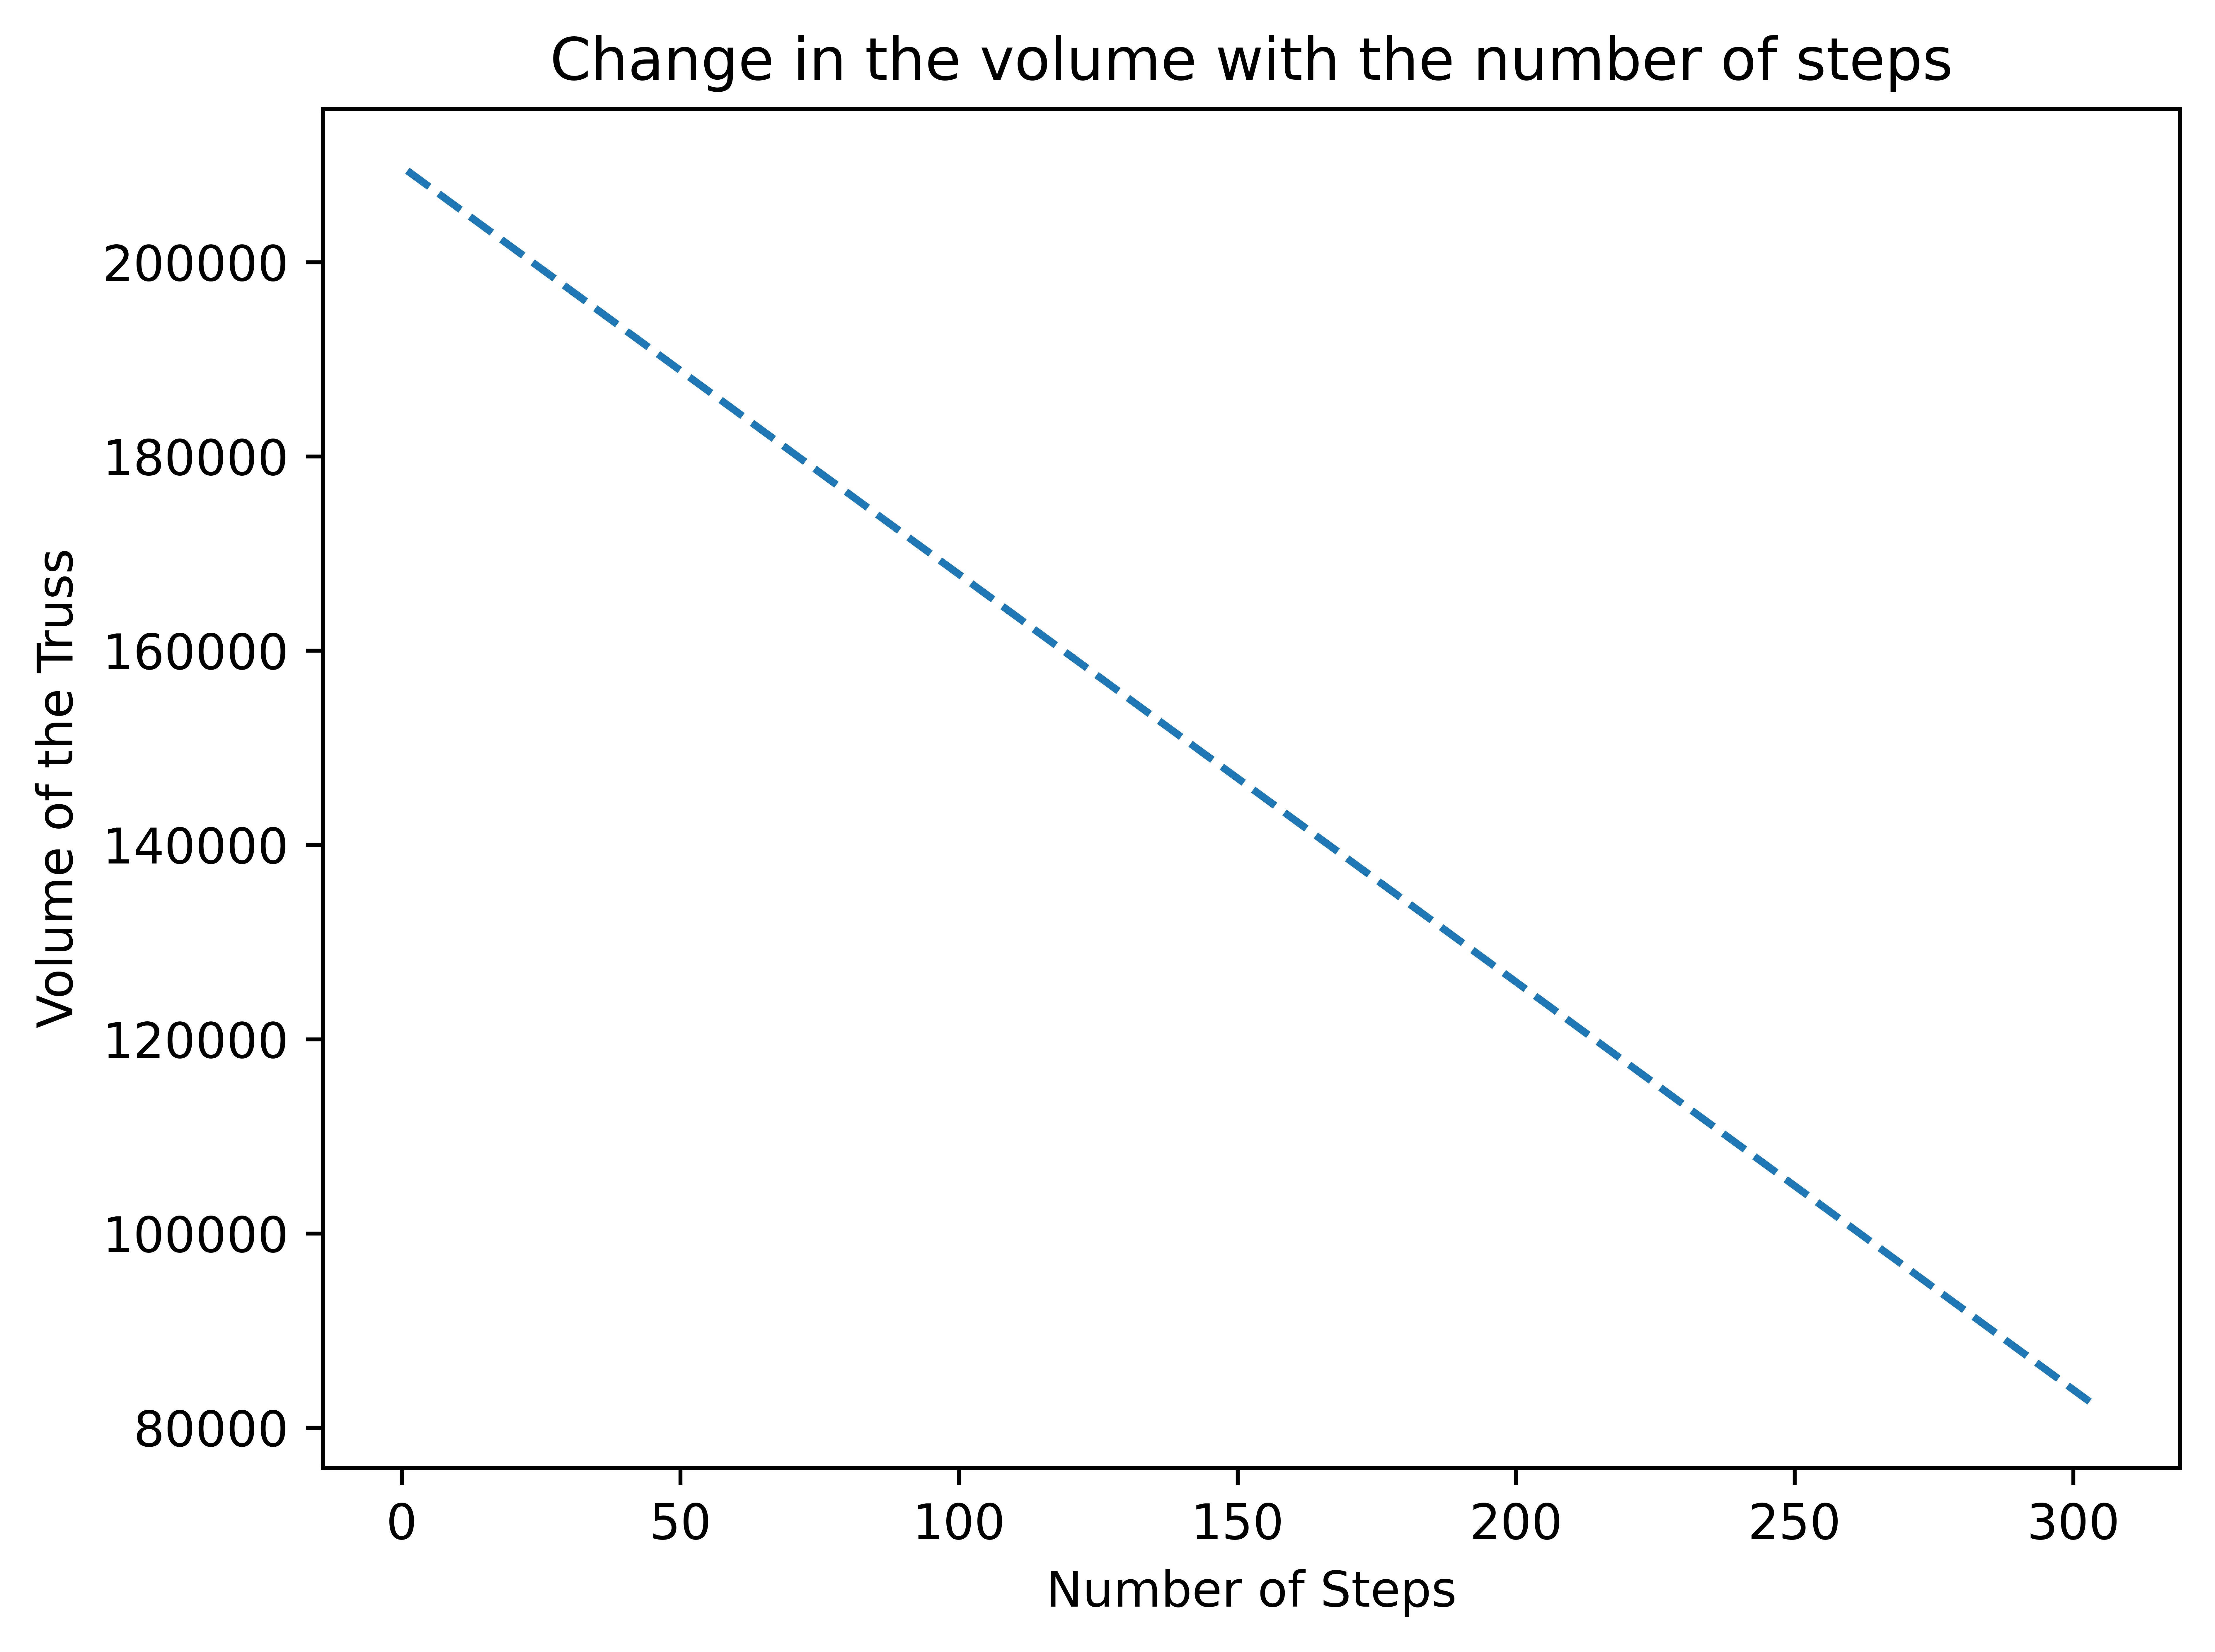

In [116]:
plt.plot(np.linspace(1, len(gd[1]), len(gd[1])), gd[1], "--")
plt.title("Change in the volume with the number of steps")
plt.xlabel("Number of Steps")
plt.ylabel("Volume of the Truss")
plt.tight_layout()
plt.show()

In [63]:
alpha = np.array([0.01]*len(x)) # learning rate 
beta1 = np.array([0.9]*len(x)) # decay rate for first moment estimate
beta2 = np.array([0.999]*len(x)) # 0.999 # decay rate for second moment estimate
eps = np.array([1e-8]*len(x))  # small constant to avoid division by zero
m = np.zeros_like(x) # first moment estimate
v = np.zeros_like(x) # second moment estimate
t = 0 # iteration counter